# Data Processing and Loading

Note: This notebook combines the augmentation proposed in YoloV3 with pretrained data from Pseudo Labeling?

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
godimg = 0

In [3]:
from utils import load_data, load_image, load_mosaic, random_affine, \
                    augment_hsv, letterbox, get_datasets, get_data_loader

# Set environment
ENV = 'kaggle' 

# Set data directory
if ENV == 'gcloud':
    DIR_INPUT = 'data'
elif ENV == 'kaggle':
    DIR_INPUT = '../input/global-wheat-detection'
else:
    print("Error: invalid environment specified")
    
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [4]:
# Load raw data
train_df, valid_df, test_df = load_data(DIR_INPUT)

In [5]:
# Augment datasets (test is not augmented), inspired by CutMix and MixMatch
train_dataset, valid_dataset, test_dataset = get_datasets(train_df, valid_df, test_df, 
                                                          DIR_TRAIN, DIR_TEST)

In [6]:
# Get data loader for training loop
BATCH_TR = 8
BATCH_VAL = 4
BATCH_TE = 4

train_data_loader = get_data_loader(train_dataset, 
                                    batch_size=BATCH_TR,
                                    drop_last=True)

valid_data_loader = get_data_loader(valid_dataset, 
                                    batch_size=BATCH_VAL, 
                                    shuffle=False)

test_data_loader = get_data_loader(test_dataset, 
                                   batch_size=BATCH_TE, 
                                   shuffle=False)

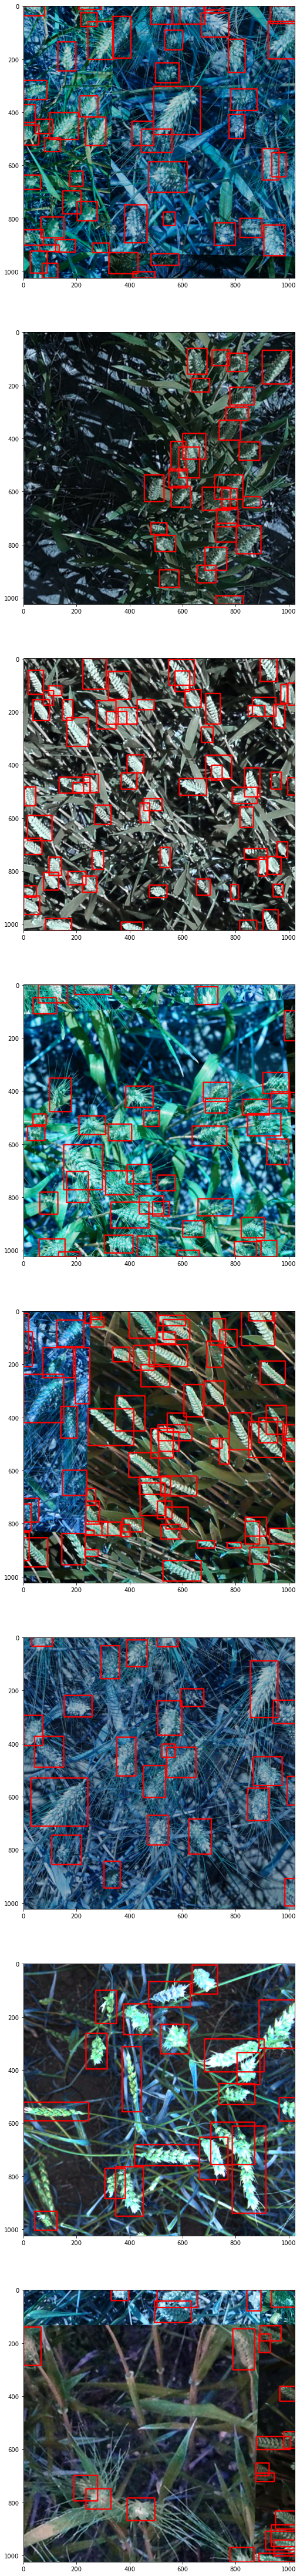

In [6]:
# Check data augmentation and loading
images, targets = next(iter(train_data_loader))
fig, ax = plt.subplots(8, 1, figsize=(160, 80))

for i in range(8):  
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()

    for box in boxes:
        cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])), 
                   220, 3)

    ax[i].imshow(sample)
plt.show()

# Model Training
We will be using pretrained pseudo labeling weights for better results.
<br>
<br>
We will be training for multiple epochs and saving the weights when the validation loss is the least. This will help us in getting the best weights file and avoid overfitting.

In [16]:
from utils import Averager

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
# Initialize the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
model.to(device)

# Set region of interest classifier
num_classes = 2  # output classes: wheat, background
in_features = model.roi_heads.box_predictor.cls_score.in_features # input features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace pre-trained

# Load model weights
WEIGHTS_FILE = "fasterrcnn_resnet50_fpn2nd.pth"
if ENV == 'kaggle':
    WEIGHTS_FILE = '../input/fork-of-fasterrcnn-pseudo-labeling/fasterrcnn_resnet50_fpn2nd.pth'
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))

<All keys matched successfully>

In [19]:
# Choose optimizer, learning rates, epochs
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
# lr_scheduler = None

num_epochs = 2 # Increase for better results

In [20]:
# Training loop
loss_hist = Averager()
val_loss_hist = Averager()
itr = 1
least_loss = float('inf')

for epoch in range(num_epochs):
    loss_hist.reset()
    val_loss_hist.reset()
    
    # Train step
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # Validation Step
    for images, targets in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        val_loss_dict = model(images, targets)

        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()

        val_loss_hist.send(val_loss_value)

    
    # Update best model or the learning rate
    if val_loss_hist.value < least_loss:
        least_loss = val_loss_hist.value
        lval=int(least_loss*1000)/1000
        torch.save(model.state_dict(), f'fasterrcnn_custom_test_ep{epoch}_loss{lval}.pth')
        torch.save(model.state_dict(), 'best_weights.pth')
        
    else:
        if lr_scheduler is not None:
            lr_scheduler.step()
    print(f"Epoch #{epoch} train_loss: {loss_hist.value} val_loss: {val_loss_hist.value}")

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #50 loss: 0.7036553621292114
Iteration #100 loss: 0.6579549312591553
Iteration #150 loss: 0.7599806785583496
Iteration #200 loss: 0.6673992872238159
Iteration #250 loss: 0.6850482225418091
Iteration #300 loss: 0.7881783246994019
Epoch #0 train_loss: 0.674234337972466 val_loss: 0.6480748276867553
Iteration #350 loss: 0.697039008140564
Iteration #400 loss: 0.5723627209663391
Iteration #450 loss: 0.661928653717041
Iteration #500 loss: 0.6340057849884033
Iteration #550 loss: 0.6580014228820801
Iteration #600 loss: 0.6544945240020752
Iteration #650 loss: 0.6458232402801514
Epoch #1 train_loss: 0.6327349985315955 val_loss: 0.6284719785887324


In [22]:
ls 

__notebook_source__.ipynb  fasterrcnn_custom_test_ep0_loss0.648.pth
best_weights.pth           fasterrcnn_custom_test_ep1_loss0.628.pth


# Inference on Validation Dataset

In [20]:
from utils import format_prediction_string, predict_bbox

In [21]:
# Convert model from training to eval mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [22]:
# Predict labels for new images
detection_threshold = 0.5
is_submission=False
results = []

for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    results += predict_bbox(images, image_ids, model, detection_threshold, is_submission)    

if is_submission:
    new_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
else:
    new_df = pd.DataFrame(results, columns=['image_id','x','y','w','h'])

print(new_df)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428190859/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


NameError: name 'detection_threshold' is not defined

In [30]:
# sample = images[1].permute(1,2,0).cpu().numpy()
# boxes = outputs[1]['boxes'].data.cpu().numpy()
# scores = outputs[1]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

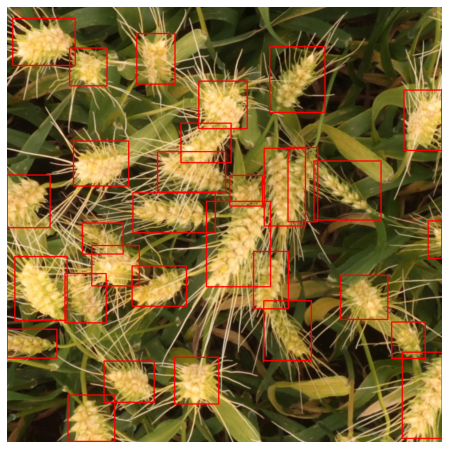

In [31]:
# TODO: adapt to new_df dataframe
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
test_df.to_csv('submission.csv', index=False)

# Justin TODO

- Try to store everything in memory instead of using dataloader (figure out how to batch with that), see if that's any faster (possible that it doesn't really help us since the infrastructure loss, but research pytorch to see if they have recommendations here)

- Try with more augmentations and different pretrained

- Freeze the train/val splits so we can do offline evaluations on them all --> NOTE sort of already done in util.py load_data fn?

- Misclassification analysis

# DONE

- move code around (utils.py file probably)